In [40]:
"""
Script to process all the LCDRI data, generate 1D surface wave spectra, and calculate significant wave heights

"""


from scipy.io import loadmat, savemat
from scipy import signal
from scipy.io import netcdf
import numpy as np
import time
import pyIGRF
import datetime
import pandas as pd
import matplotlib.pyplot as plt
#from wavesim1d import *
from src.em_apex_processing import *
from src.spectral_processing import *
import os
import warnings



#########################
#####Define Constants####
#########################
Cmax=10
uVpc = 1e6 * (10e-3 / (2**24))

#Degree of polynomial fit
Nfit=1

nstep_off=25
navg_off=50
base_fr=0.02

ch=0.06
cz=0.09

nstep = 60
navg = 120 
Zmax=100
Dirmax=80
#electrode separation
esep1 = (8+5/8)*0.0254 # m
esep2 = (8+5/8)*0.0254 # m
c1 = 0.5
c2 = -0.2
# angles between compass and electrode axes
alpha2 = 1.95
alpha1 = alpha2 - np.pi/2
###########################


nblock = 120
fs = 1
overlap = 60

### Load Files ###
#For loading from harddrive
#fname_base = "/Volumes/TFO-5TB-3/TFO/LCDRI/raw_data/"
#For loading from laptop
fname_base = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/EmApex_Data/lcdri/"
float_list = os.listdir(fname_base)

#Initialize arrays for storing stuff
big_spec_store = []
big_time_store = []
big_up_down_store = []
big_prof_store = []
big_uncertainty_store = []
big_loc_store = []
big_prof_speed_store = []
big_rotf_store = []
resid_store = np.array([])


up_count = 0
down_count = 0
up = True

float_id_counter = 0
ignore_count = 0
too_deep_counter = 0



for float_id in float_list:
    
    if "grid" in float_id:
        continue
    if ".DS_" in float_id:
        continue
        
    dec_name = fname_base+float_id+"/dec/"
    
    #Loop through each profile for that float
    files = os.listdir(dec_name)
    efr_files = [file for file in files if "efr.mat" in file and not file.startswith('.')]
    
    spec_store = np.zeros((len(efr_files), 2 , (nblock//2)-1))
    time_store = np.zeros(len(efr_files))
    up_down_store = np.zeros(len(efr_files))
    prof_speed_store = np.zeros(len(efr_files))
    rotf_store = np.zeros(len(efr_files))
    uncertainty_store = np.zeros((len(efr_files), 2))
    loc_store = np.zeros((len(efr_files), 2))
    prof_store = np.empty(len(efr_files), dtype=object)
    
    counter=0
    #Load each profiling file, and then calculate the 1D spectrum
    for file in efr_files:
        fname = dec_name + file
        EFR = loadmat(fname)

        
        prof_num = int(file.split('-')[2])
        #Load the UXT times, and correct
        
        efr_times = EFR['UXT'] - EFR['AGE']
        efr_times = efr_times[0, :]
        seqno = EFR['SEQNO'][0, :]
        
        #Fit UXT times to sequence number (measurement # for that profile) to make sure monotonically increasing
        p = np.polyfit(seqno,efr_times,1)
        pfit = np.poly1d(p)
        mlt_efr = pfit(seqno);

        
        #Load GPS file for calculating 
        # gps files are only on up profiles (even)
        if prof_num%2==0:
            up = True
            cut = fname.find("efr")
            gpsfname = fname[:cut]+"gps.mat"
        else:
            up = False
            new_file = file.split('-')[0]+'-'+file.split('-')[1]+'-{:04d}'.format(prof_num+1)+'-gps.mat'
            gpsfname = dec_name+new_file
        GPS = loadmat(gpsfname)

        #Load CTD file 
        cut = fname.find("efr")
        ctdfname = fname[:cut]+"ctd.mat"
        CTD = loadmat(ctdfname)
        
        ctd_time = CTD["UXT"][0, :]
        P = CTD["P"][0, :]
        Pef = np.interp(mlt_efr, ctd_time, P)

        tim_pd = pd.to_datetime(GPS["UXT_GPS"][0, :],unit='s', utc=True,)
        
        #Convert time to fractional year for use in the igrf function
        frac_yrs = np.array([year_fraction(dt) for dt in tim_pd])
        avg_lat = np.nanmean(GPS["LAT"][0, :])
        avg_lon = np.nanmean(GPS["LON"][0, :])
        avg_frac_yrs = np.nanmean(frac_yrs)

        #Get magnetic field values
        [Bx, By, Bz, f] = pyIGRF.calculate.igrf12syn(avg_frac_yrs, 1, 0, avg_lat, avg_lon)
        #get conversion factor for converting to velocity
        fz=-np.nanmean(Bz);
        fh=np.nanmean(np.sqrt(Bx**2+By**2));
        sfv1 = 1e3/(fz*esep1*(1.0+c1));
        sfv2 = 1e3/(fz*esep2*(1.0+c1));
        
        #Convert from counts to microvolts
        E1 = (EFR["E1"][0, :]-2**23) * uVpc;
        E2 = (EFR["E2"][0, :]-2**23) * uVpc;
        
        #pull out compass values
        HZ = EFR["HZ"][0, :];
        HY = EFR["HY"][0, :];
        HX = EFR["HX"][0, :];
        
        
        #If up is true, flip everything
        if up:
            E1 = np.flip(E1)
            E2 = np.flip(E2)
            HZ = np.flip(HZ)
            HX = np.flip(HX)
            HY = np.flip(HY)
            Pef = np.flip(Pef)
            mlt_efr = np.flip(mlt_efr)
        
        else:
            #Do Nothing
            pass
            
        
        #Remove the beginning of the timesereis before the float starts moving
        #Need to do this for all of E1, E2, HX, HY, mlt_efr
        moving_inds = get_moving_inds(Pef)
            
        #Apply moving_inds to the EM timeseries
        E1 = E1[moving_inds]
        E2 = E2[moving_inds]
        HX = HX[moving_inds]
        HY = HY[moving_inds]
        mlt_efr = mlt_efr[moving_inds]
        Pef = Pef[moving_inds]
        
        #[HX, HY] = correct_magnetometer(HX, HY)
        
        #Do the 50s fits 
        [e1offs,e2offs,e1fits,e2fits,anghxhy, resid] = em_offset(Nfit,mlt_efr,nstep_off,navg_off,E1,E2,HX,HY)

        #Get overall fi and calculate the residuals
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            e1off=np.nanmean(e1offs,1)
            e2off=np.nanmean(e2offs,1)
            e1fit=np.nanmean(e1fits,1)
            e2fit=np.nanmean(e2fits,1)
            resid = np.nanmean(resid,1)

        #Calculate the residual
        e1r = E1 - e1fit
        e2r = E2 - e2fit

        ## Do spike detection
        #If either channel has large spikes (edge case for a single profile), ignore the profile.
        spikes=contains_spikes(E1, E2)
        if spikes:
            print(fname)
            continue
        
        
        #Now need to convert to velocity (m/s)
        e1r = e1r*sfv1
        e2r = e2r*sfv2
        

        #Now use the angles to rotate to x-y coordinates
        avg_angs = np.copy(anghxhy)
        avg_angs[~np.isnan(avg_angs)] = np.unwrap(avg_angs[~np.isnan(avg_angs)])
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            avg_angs = np.nanmean(avg_angs, axis=1)

            
        #Trigonometry to get in x-y coordinates
        E2_r=e2r*np.cos(avg_angs)+e1r*np.sin(avg_angs)
        E1_r=-e2r*np.sin(avg_angs)+e1r*np.cos(avg_angs)
        
        #Applying the angular offset between the magnetometer axes and the electrode axes
        E_x = E1_r*np.cos(alpha1)-E2_r*np.sin(alpha1)
        E_y = E1_r*np.sin(alpha1)+E2_r*np.cos(alpha1)
        
        #Now apply a highpass filter to the data to remove the noise at low frequencies 
        sos = signal.butter(10, 0.04, 'hp', fs=1, output='sos')
        E_x_filtered = signal.sosfilt(sos, E_x)
        E_y_filtered = signal.sosfilt(sos, E_y)
        
        E_x = E_x_filtered
        E_y = E_y_filtered
        
        
        #in the case where the float doesn't actually move for nblock measurements, need to skip it
        if len(E_x)<nblock:
            continue
      
        #reshape the u and v profiles into 
        [u_x, z_x] = reshape_u(E_x, Pef, nblock, overlap, fs)
        [u_y, z_y] = reshape_u(E_y, Pef, nblock, overlap, fs)
        #get t_new in the same shape as u_x and z_x for calculating mean profiling speed
        [_, t_new] = reshape_u(E_x, mlt_efr, nblock, overlap, fs)
        
        #Calculate mean profiling speed
        prof_speed = np.abs(z_x[:, 0]-z_x[:, -1])/np.abs(t_new[:, 0]-t_new[:, -1])
        
        if u_x.shape[0]==1:
            continue
            
            
        #Get the rotation frequency
        time_s = np.abs(mlt_efr - mlt_efr[0])
        rad_per_s = np.gradient(avg_angs, time_s) #radians per second. rotation period is 2pi/rad_per_s
        rotf = rad_per_s/2/np.pi
        
        [rotf_reshaped, _] = reshape_u(rotf, Pef, nblock, overlap, fs)
        
        window_rotf = np.nanmean(rotf_reshaped, axis=1)
        
            
        UUwindow, fwindow = make_vel_spectrum(u_x, fs)

        VVwindow, fwindow = make_vel_spectrum(u_y, fs)

        min_z = np.min(Pef)
            
        if min_z>20:
            too_deep_counter+=1
        else:  


            UU = UUwindow/(int(nblock/2)*fs)
            Exx = UU[:,1:]/ (np.square((2*np.pi*fwindow[1:])))
            VV = VVwindow/(int(nblock/2)*fs)
            Eyy = VV[:,1:]/ (np.square((2*np.pi*fwindow[1:])))

            Eh = Exx+Eyy
            
                
            [Eh_Eric1, Eh_Eric2, Eh_Eric3, Eh_Eric4] = depth_correct_Eric(Eh, fwindow[1:], z_x, prof_speed, nblock, Cmax, fs)

            
            if np.isnan(Eh_Eric4).all():
                continue
            
            u_noise = 0 #This is just for testing...
            [lbound, ubound] = get_spectral_uncertainity(E_x, E_y, Pef, u_noise, prof_speed, nblock, overlap, Cmax, fs)
            
            #Average each profile spec and add to the array for storing/saving
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)
                spec_store[counter, 0, :] = np.nanmean(Eh, axis=0)
                spec_store[counter, 1, :] = np.nanmean(Eh_Eric4, axis=0)
                prof_speed_store[counter] = np.nanmean(prof_speed)
                rotf_store[counter]=np.nanmean(window_rotf)
                time_store[counter] = np.nanmean(mlt_efr)
                prof_store[counter] = float_id+"_"+str(prof_num)
                
                uncertainty_store[counter, :] = np.array([lbound, ubound])
                loc_store[counter, :] = np.array([avg_lat, avg_lon])
                if prof_num%2==0:
                    #Then it's even and its an up profile
                    up_down_store[counter] = 1
                else:
                    up_down_store[counter] = 0

        
        
            counter+=1
        
        
    
    # Now store each one in a big array for sorting etc later
    if float_id_counter==0:
        big_spec_store=spec_store
        big_uncertainty_store = uncertainty_store
        big_time_store = time_store
        big_up_down_store = up_down_store
        big_prof_store = prof_store
        big_loc_store = loc_store
        big_prof_speed_store = prof_speed_store
        big_rotf_store = rotf_store
    else:
        big_spec_store = np.append(big_spec_store, spec_store, axis=0)
        big_uncertainty_store = np.append(big_uncertainty_store,uncertainty_store, axis=0)
        big_time_store = np.append(big_time_store, time_store)
        big_up_down_store = np.append(big_up_down_store, up_down_store)
        big_prof_store = np.append(big_prof_store, prof_store)
        big_prof_speed_store = np.append(big_prof_speed_store, prof_speed_store)
        big_rotf_store = np.append(big_rotf_store, rotf_store)
        big_loc_store = np.append(big_loc_store, loc_store, axis=0)
        

    
    float_id_counter+=1
        


/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/EmApex_Data/lcdri/6667i/dec/ema-6667i-0062-efr.mat


In [41]:
#Cell for sorting the arrays by time

cdip_color='#F5B958'
red_color = '#D81159'
gray_color= '#2E2836'

#Getting rid of the profiles where minimum depth was below 20m
kill = np.where(big_spec_store[:, 0, 5]==0)


spec_store_shallow = np.delete(big_spec_store, kill[0], axis=0)
time_store_shallow = np.delete(big_time_store, kill[0], axis=0)
up_down_store_shallow = np.delete(big_up_down_store, kill[0], axis=0)
prof_store_shallow = np.delete(big_prof_store, kill[0], axis=0)
uncertainty_store_shallow = np.delete(big_uncertainty_store, kill[0], axis=0)
loc_store_shallow = np.delete(big_loc_store, kill[0], axis=0)
big_prof_speed_shallow = np.delete(big_prof_speed_store, kill[0], axis=0)
big_rotf_shallow = np.delete(big_rotf_store, kill[0], axis=0)

out = zip(spec_store_shallow, up_down_store_shallow, time_store_shallow, prof_store_shallow)
out2 = zip(uncertainty_store_shallow, time_store_shallow, loc_store_shallow,big_prof_speed_shallow, big_rotf_shallow)
#list(out)[0]
sorted_array = sorted(out, key=lambda tup: tup[2])
sorted_array2 = sorted(out2, key=lambda tup: tup[1])

unzipped = ([ a for a,b,c,d in sorted_array ], [ b for a,b,c,d in sorted_array ], [c for a,b,c,d in sorted_array], [d for a,b,c,d in sorted_array])
unzipped2 = ([ a for a,b,c,d,e in sorted_array2 ], [ b for a,b,c,d,e in sorted_array2 ], [c for a,b,c,d,e in sorted_array2], [d for a,b,c,d,e in sorted_array2], [e for a,b,c,d,e in sorted_array2])

spec_store_sorted = np.array(unzipped[0])
up_down_store_sorted = np.array(unzipped[1])
time_store_sorted = np.array(unzipped[2])
prof_store_sorted = np.array(unzipped[3])

uncertainty_store_sorted = np.array(unzipped2[0])
loc_store_sorted = np.array(unzipped2[2])
prof_speed_store_sorted = np.array(unzipped2[3])
rotf_store_sorted = np.array(unzipped2[4])

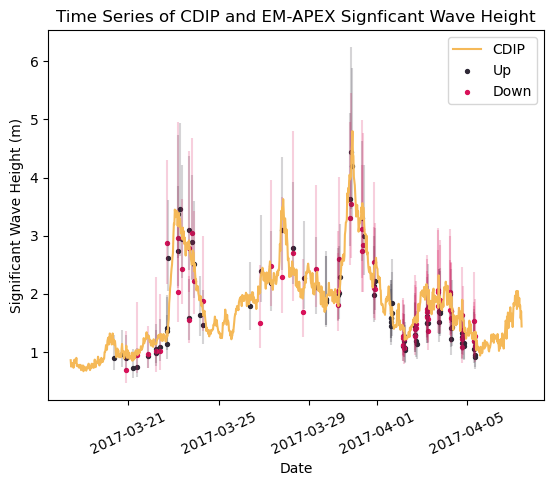

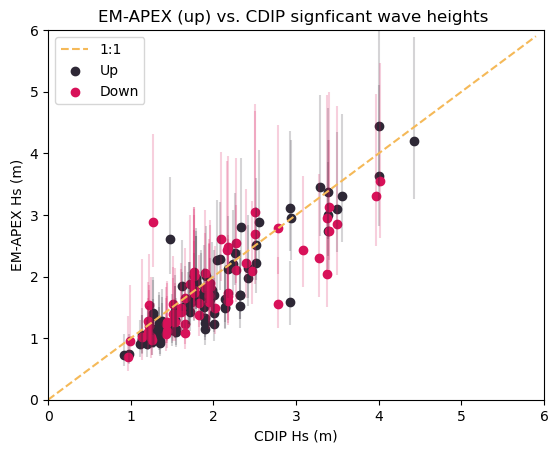

In [44]:
#Cell for plotting time series of significant wave heights and scatter plots of cdip vs. EM-APEX

spec_store_sorted_new_raw = spec_store_sorted[:, 0, :]
spec_store_sorted_new_corr = spec_store_sorted[:, 1, :]

#Add a high frequency tail for the purpose of calculating swh
spec_store_sorted_new_corr = add_hf_tail(spec_store_sorted_new_corr, fwindow[1:])
sig_wave_array = [];

[Hs,lower,upper] = sig_wave_height(fwindow, np.transpose(spec_store_sorted_new_raw))
[Hs_corr, lower, upper] = sig_wave_height(fwindow, np.transpose(spec_store_sorted_new_corr), uncertainty_store_sorted)

errors = np.zeros((2, len(lower)))
errors[0,:]=lower
errors[1,:]=upper

t_apex = np.array([datetime.datetime.fromtimestamp(t) for t in time_store_sorted])

ups = np.where(up_down_store_sorted==1)[0]
downs = np.where(up_down_store_sorted==0)[0]

##Get Errors
#first need to match up teh 
cdip_inds = np.array([], dtype=int)
for ind in range(0, len(time_store_sorted[ups])):
    ind2 = np.where(np.abs(time_store_sorted[ups][ind]-times)==np.min(np.abs(time_store_sorted[ups][ind]-times)))
    #plt.loglog(wave_freq, energy_density[ind2[0][0], :], label="CDIP")
    cdip_inds = np.append(cdip_inds, ind2[0])

    
cdip_inds_down = np.array([], dtype=int)
for ind in range(0, len(time_store_sorted[downs])):
    ind2 = np.where(np.abs(time_store_sorted[downs][ind]-times)==np.min(np.abs(time_store_sorted[downs][ind]-times)))
    #plt.loglog(wave_freq, energy_density[ind2[0][0], :], label="CDIP")
    cdip_inds_down = np.append(cdip_inds_down, ind2[0])


#plt.plot(t_apex, Hs, color='k', linewidth=1, alpha=0.5, label='EM-APEX raw')
plt.scatter(t_apex[ups], Hs_corr[ups], color=gray_color, s=8, label='Up')
plt.scatter(t_apex[downs], Hs_corr[downs], color=red_color, s=8, label='Down', )
plt.errorbar(t_apex[ups], Hs_corr[ups], yerr = errors[:, ups], color=gray_color, alpha=0.2, fmt='none')
plt.errorbar(t_apex[downs], Hs_corr[downs], yerr = errors[:, downs], color=red_color, alpha=0.2, fmt='none')


#plt.plot(t_apex, Hs_corr, '--C4', label='EM-APEX corrected')


fname = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/229p1_d01.nc"

nc = netcdf.NetCDFFile(fname, 'r', mmap=False) #Not sure why I need to do mmap = False but it gets rid of a warning
times = nc.variables['waveTime'][:]
ts = np.array([datetime.datetime.fromtimestamp(t) for t in times])
Hs_cdip = nc.variables['waveHs'][:]
energy_density = nc.variables['waveEnergyDensity'][:]
wave_freq = nc.variables['waveFrequency'][:]
cdip_lat = np.nanmean(nc.variables['gpsLatitude'][:])
cdip_lon = np.nanmean(nc.variables['gpsLongitude'][:])

#dtimes = datetime(time, 'convertfrom', 'posixtime');
nc.close()
plt.plot(ts, Hs_cdip, label='CDIP', color='#F5B958')

#plt.scatter(swift_t_out, swift_arr[:, 3], s=6, alpha=0.2, color='k')

plt.ylabel("Significant Wave Height (m)")
plt.xlabel('Date')
plt.xticks( rotation=25 )
plt.title("Time Series of CDIP and EM-APEX Signficant Wave Height")
plt.legend()

#plt.savefig("/Users/jamesstadler/Documents/UW/TFO/Figures/LCDRI/JTECH_Paper/CDIP_EM_Hs_Timeseries.png", bbox_inches='tight')


#Up figure
plt.figure()
plt.errorbar(Hs_cdip[cdip_inds], Hs_corr[ups], yerr = errors[:, ups], color=gray_color, alpha=0.2, fmt='none')
plt.scatter(Hs_cdip[cdip_inds], Hs_corr[ups], color=gray_color, label="Up")

plt.errorbar(Hs_cdip[cdip_inds_down], Hs_corr[downs], yerr = errors[:, downs], color=red_color, alpha=0.2, fmt='none')
plt.scatter(Hs_cdip[cdip_inds_down], Hs_corr[downs], color=red_color, label="Down")



y = np.arange(0, 6, 0.1)
plt.plot(np.arange(0, 6, 0.1), y, '--',color=cdip_color, label="1:1")
plt.xlim([0, 6])
plt.ylim([0, 6])
plt.xlabel("CDIP Hs (m)")
plt.ylabel("EM-APEX Hs (m)")
plt.title("EM-APEX (up) vs. CDIP signficant wave heights ")
plt.legend()
#plt.savefig("/Users/jamesstadler/Documents/UW/TFO/Figures/LCDRI/JTECH_Paper/APEX_vs_CDIP_hs.png", bbox_inches='tight')



Text(0.5, 1.0, 'EM-APEX Peak Periods vs. CDIP buoy')

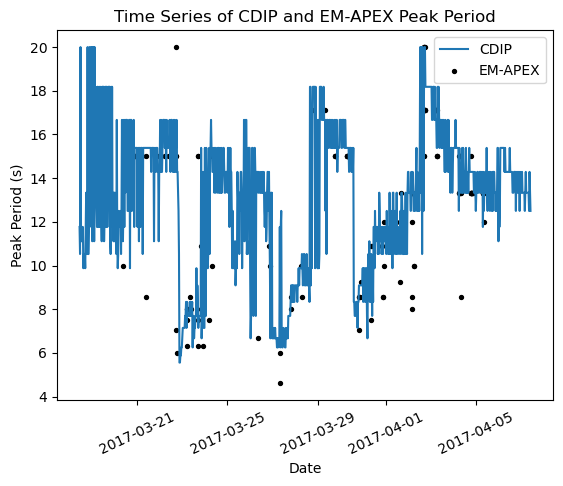

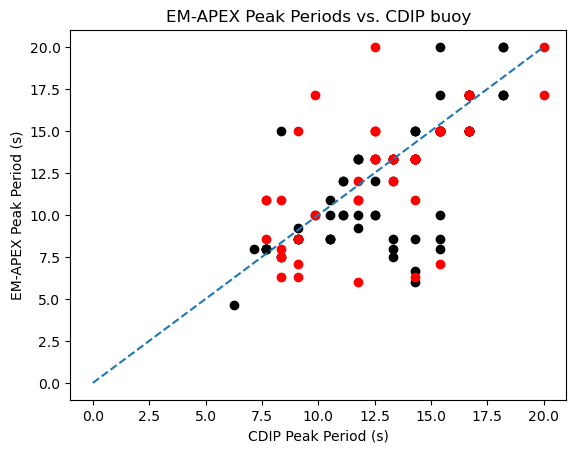

In [51]:
#Cell for plotting peak frequency time series for both CDIP and EM-APEX buoys
[peak_freq, peak_spl] = get_peak_freq(fwindow[1:], spec_store_sorted_new_corr)

#Plot timeseries of peak frequency
plt.figure()
plt.scatter(t_apex, 1/peak_freq, color='k', s=8, label="EM-APEX")

[peak_freq_cdip, peak_spl_cdip] = get_peak_freq(wave_freq, energy_density)

plt.plot(ts, 1/peak_freq_cdip, label="CDIP")
plt.ylabel("Peak Period (s)")
plt.xlabel('Date')
plt.xticks( rotation=25 )
plt.title("Time Series of CDIP and EM-APEX Peak Period")
plt.legend()

cdip_inds = np.array([], dtype=int)
for ind in range(0, len(time_store_sorted)):
    ind2 = np.where(np.abs(time_store_sorted[ind]-times)==np.min(np.abs(time_store_sorted[ind]-times)))

    cdip_inds = np.append(cdip_inds, ind2[0])
    
    
#Plot scatter plot of peak frequecny
plt.figure()
plt.scatter(1/peak_freq_cdip[cdip_inds][ups], 1/peak_freq[ups], color='k', label="Ups")
plt.scatter(1/peak_freq_cdip[cdip_inds][downs], 1/peak_freq[downs], color='r', label="Downs'")


y = np.arange(0, 20, 0.1)
plt.plot(np.arange(0, 20, 0.1), y, '--')

plt.xlabel("CDIP Peak Period (s)")
plt.ylabel("EM-APEX Peak Period (s)")
plt.title("EM-APEX Peak Periods vs. CDIP buoy")

(0.0, 5.0)

<Figure size 640x480 with 0 Axes>

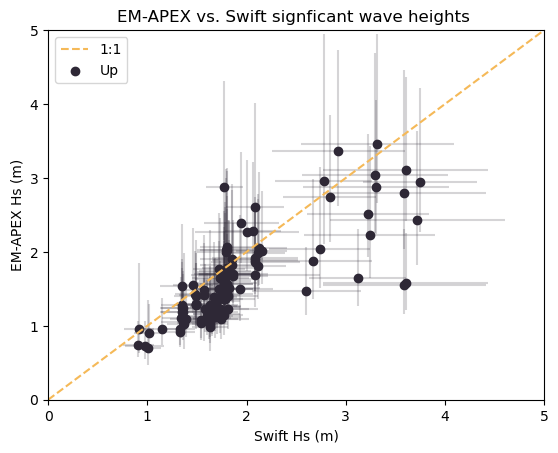

In [49]:
#Load SWIFT Data
##TO DO: Need to put all the swift data into 


swift_folder = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/SWIFT/SWIFTprocessed/"

files = os.listdir(swift_folder)
swift_loc_storer = {}
swift_arr = np.array([[0,0,0,0]])

for file in files:
    lat_arr = np.array([])
    lon_arr = np.array([])
    swift_fname = swift_folder+file
    name_tag = swift_fname.split('.')[0]
    SWIFT = loadmat(swift_fname)

    swift = np.transpose(SWIFT['SWIFT'])
    if swift.size==0:
        continue
    else:
        mdtype = swift.dtype
        ndata = {n: swift[n] for n in mdtype.names}
        columns = [n for (n, v) in ndata.items()]
        df = pd.DataFrame(np.concatenate([ndata[c] for c in columns], axis=1, dtype='object'), columns=columns)
        lat=np.array(df['lat'], dtype=float)
        lon=np.array(df['lon'], dtype=float)
        time = np.array(df['time'], dtype=float)
        hs = np.array(df['sigwaveheight'], dtype=float)
        lat_arr = np.expand_dims(lat, axis=1)
        lon_arr = np.expand_dims(lon, axis=1)
        time_arr = np.expand_dims(time, axis=1)
        hs_arr = np.expand_dims(hs, axis=1)

        swift_temp_arr = np.hstack((time_arr, lon_arr, lat_arr, hs_arr))
        swift_arr = np.vstack((swift_arr, swift_temp_arr))
    

swift_arr = np.delete(swift_arr, 0, 0)

swift_t_out=datenum_to_datetime(swift_arr[:, 0])
swift_mean_store = np.array([], dtype=int)
swift_std_store = np.array([], dtype=int)
apex_swift_inds = np.array([], dtype=int)
counter = 0
for t in t_apex:
    blah = np.where(np.abs(t-swift_t_out)<datetime.timedelta(hours=1))
    if blah[0].size==0:
        counter+=1
        continue
    else:

        swift_mean_store = np.append(swift_mean_store, np.nanmean(swift_arr[blah, -1]))
        swift_std_store = np.append(swift_std_store, np.nanstd(swift_arr[blah, -1]))


        apex_swift_inds = np.append(apex_swift_inds, counter)
    counter+=1
    

    
#Plot the EM-APEX vs. Swift data
plt.figure()

#Up figure
plt.figure()
plt.errorbar(swift_mean_store, Hs_corr[apex_swift_inds], yerr = errors[:, apex_swift_inds], xerr=swift_std_store*2, color=gray_color, alpha=0.2, fmt='none')
plt.scatter(swift_mean_store, Hs_corr[apex_swift_inds], color=gray_color, label="Up")


y = np.arange(0, 6, 0.1)
plt.plot(np.arange(0, 6, 0.1), y, '--',color=cdip_color, label="1:1")
plt.xlim([0, 6])
plt.ylim([0, 6])
plt.xlabel("Swift Hs (m)")
plt.ylabel("EM-APEX Hs (m)")
plt.title("EM-APEX vs. Swift signficant wave heights ")
plt.legend()
plt.xlim([0,5])
plt.ylim([0,5])



6675j_82


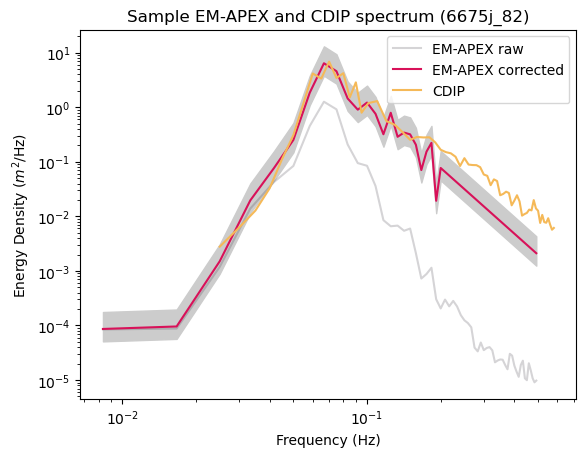

In [48]:
#Cell for checking individual spectra. Just change "ind" to whatever spectra you want to look at (sorted by time) 
#ind can range from 0 to 150

#ind = 68 #This is the bad one
#ind = 22 # This is the one for hte figure in the paper
ind=120
plt.figure()
plt.fill_between(fwindow[1:],spec_store_sorted_new_corr[ind, :]*uncertainty_store_sorted[ind, 1],spec_store_sorted_new_corr[ind, :]*uncertainty_store_sorted[ind, 0],color='0.8')
plt.loglog(fwindow[1:], spec_store_sorted_new_raw[ind, :], label="EM-APEX raw", color=gray_color, alpha=0.2)
plt.loglog(fwindow[1:], spec_store_sorted_new_corr[ind, :], label="EM-APEX corrected", color=red_color)
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"Energy Density ($m^2$/Hz)")
ind2 = np.where(np.abs(t_apex[ind]-ts)==np.min(np.abs(t_apex[ind]-ts)))
plt.loglog(wave_freq, energy_density[ind2[0][0], :], label="CDIP", color=cdip_color)


plt.legend()


plt.title("Sample EM-APEX and CDIP spectrum (" + str(prof_store_sorted[ind]) + ")")
print(prof_store_sorted[ind])
#plt.savefig("/Users/jamesstadler/Documents/UW/TFO/Figures/LCDRI/JTECH_Paper/Sample_Spectrum.png")

In [ ]:
#Loop for saving out each spectrum (with error bounds)
#ind = 1
for ind in range(0, len(Hs_corr)):
    plt.figure()
    plt.loglog(fwindow[1:], spec_store_sorted_new_raw[ind, :], label="EM-APEX raw")
    plt.loglog(fwindow[1:], spec_store_sorted_new_corr[ind, :])
    plt.xlabel("Frequency (Hz)")
    plt.ylabel(r"Energy Density ($m^2$/Hz)")
    #plt.loglog(np.log(fwindow[1:]), p(np.log(fwindow[1:])))
    #a = np.exp(fit[1])
    #b = -2#fit[0]
    #a = spec_store_sorted_new_raw[ind, 0]/np.exp(b * np.log(fwindow[1]))
    #y_fitted = a * np.exp(b * np.log(fwindow[1:]))

    #plt.loglog(fwindow[1:], y_fitted)
    #plt.loglog(fwindow[1:], spec_store_sorted_new_raw[-4, :]-y_fitted)
    ind2 = np.where(np.abs(time_store_sorted[ind]-times)==np.min(np.abs(time_store_sorted[ind]-times)))
    plt.loglog(wave_freq, energy_density[ind2[0][0], :], label="CDIP")


    #practice getting a high frequency fit
    #end_ind = np.where(np.isnan(spec_store_sorted_new_corr[ind, :]))[0][0]-1
    #f_end = fwindow[1+end_ind]
    #E_end = spec_store_sorted_new_corr[ind, end_ind]
    #b = np.log10(E_end)+5*np.log10*
    #c = E_end/f_end**(-4)
    #extension = np.power(fwindow[1:], -4)*c
    #extension[:end_ind]=0
    #temp_spec = np.copy(spec_store_sorted_new_corr[ind, :])
    #temp_spec[end_ind:]=0
    #plt.loglog(fwindow[1:], extension)

    #PLot highfrequency fit
    plt.loglog(fwindow[1:], spec_store_sorted_new_corr[ind, :], label="EM-APEX corrected")
    plt.fill_between(fwindow[1:],spec_store_sorted_new_corr[ind, :]*uncertainty_store_sorted[ind, 1],spec_store_sorted_new_corr[ind, :]*uncertainty_store_sorted[ind, 0],color='0.8')
    plt.legend()
    if up_down_store_sorted[ind]:
        plt.title("Prof # "+str(ind)+" (up)")
    else:
        plt.title("Prof # "+str(ind)+" (down)")

    #plt.savefig("/Users/jamesstadler/Documents/UW/TFO/Figures/LCDRI/EmApex_spectra/prof_"+f'{ind:03}'+".png", bbox_inches='tight')

    plt.close()
    #print(Hs[ind])
   # print(Hs_cdip[ind2])
    #print(extended_swh)
    
    #extended_spec.shape
    #print(spec_store_sorted_new_corr.shape)
    #print(up_down_store_sorted[ind])